## Exploratory data analysis  
A notebook to explore characteristics of the data

### 1. Import the libraries

In [104]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from glob import glob
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', None)

from keras.preprocessing import text, sequence
from tensorflow import keras
from keras.utils import np_utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from transformers import AutoModel, AutoTokenizer

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### 2. Load the data

In [68]:

train_df = pd.read_json('data/stock_train.json')
test_df = pd.read_json('data/stock_test.json')
full_df = pd.read_json('data/stock_full.json')

In [37]:
train_df.head()

,text,label
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive


In [38]:
test_df.head()

,text,label
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1516 non-null   object
 1   label   1516 non-null   object
dtypes: object(2)
memory usage: 23.8+ KB


In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1002 non-null   object
 1   label   1002 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [41]:
train_df.isna().sum()

text     0
label    0
dtype: int64

In [42]:
test_df.isna().sum()

text     0
label    0
dtype: int64

### 3. Univariate Analysis

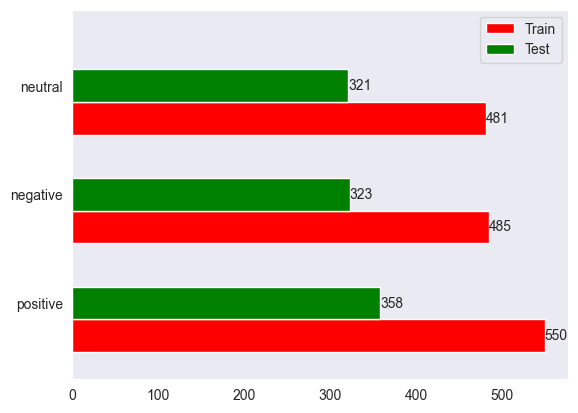

In [70]:
train_label_counts = train_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

df = pd.DataFrame({'graph': train_label_counts.index,
                   'train': train_label_counts.values,
                   'test': test_label_counts.values})

width = 0.3
ind = np.arange(len(df))
fig, ax = plt.subplots()

train_bars = ax.barh(ind, df['train'], width, color='red', label='Train')
test_bars = ax.barh(ind + width, df['test'], width, color='green', label='Test')
ax.set(yticks=ind + width, yticklabels=df['graph'])
ax.set_ylim([2 * width - 1, len(df)])

for bar in train_bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, width, ha='left', va='center')

for bar in test_bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, width, ha='left', va='center')


ax.legend()
plt.show()

### 2.1. Train Datasets

In [63]:
train_texts = train_df['text']
train_labels = train_df['label']
train_text_len = np.array([len(wd.split(' ')) for wd in train_texts])

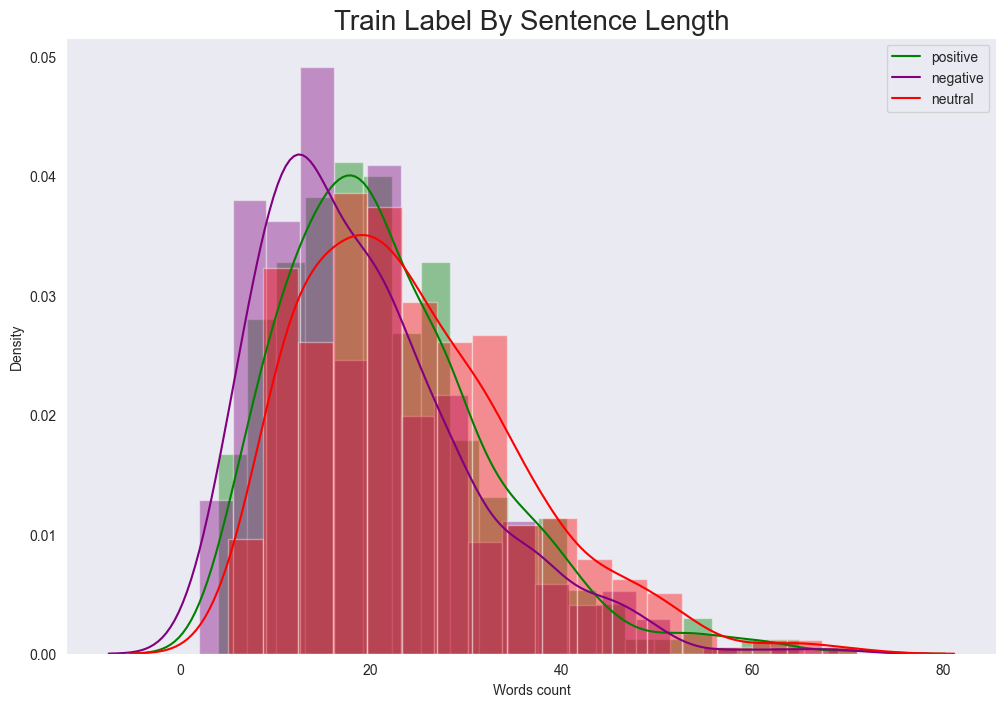

In [64]:
plt.subplots(figsize=(12,8))
sns.distplot(train_text_len[(train_labels == 'positive')], color='g')
sns.distplot(train_text_len[(train_labels == 'negative')], color='purple')
sns.distplot(train_text_len[(train_labels == 'neutral')], color='r')
plt.legend(['positive', 'negative', 'neutral'])
plt.title('Train Label By Sentence Length', fontsize=20)
plt.xlabel('Words count')
plt.show()


### 2.2. Test Datasets

In [66]:
test_texts = test_df['text']
test_labels = test_df['label']
test_text_len = np.array([len(wd.split(' ')) for wd in test_texts])

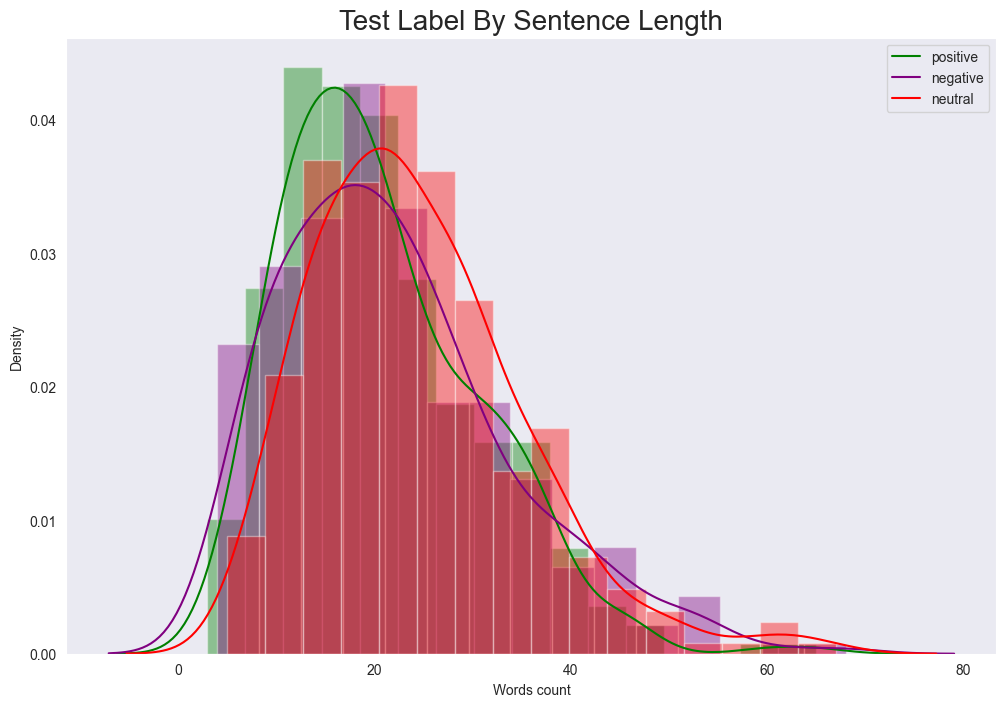

In [67]:
plt.subplots(figsize=(12,8))
sns.distplot(test_text_len[(test_labels == 'positive')], color='g')
sns.distplot(test_text_len[(test_labels == 'negative')], color='purple')
sns.distplot(test_text_len[(test_labels == 'neutral')], color='r')
plt.legend(['positive', 'negative', 'neutral'])
plt.title('Test Label By Sentence Length', fontsize=20)
plt.xlabel('Words count')
plt.show()

### 2.3. Word Clouds

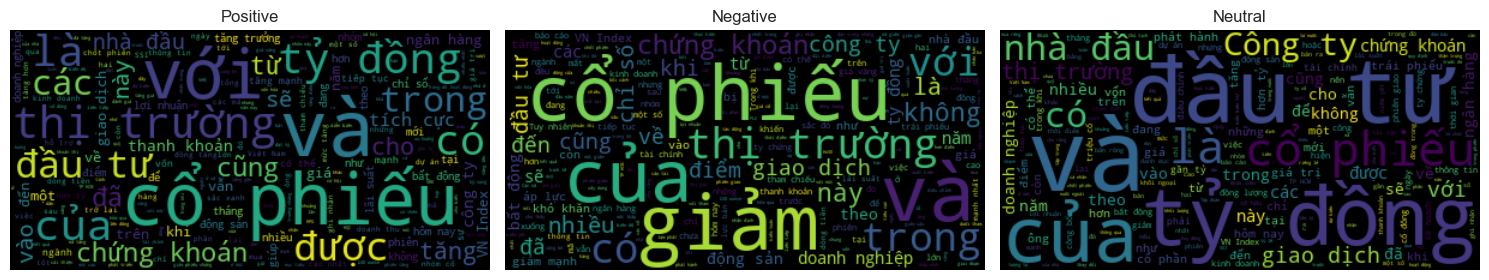

In [90]:
full_texts = full_df['text']
labels = full_df['label'].unique()

fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))
for i, label in enumerate(labels):
    text = ' '.join(full_df[full_df['label'] == label]['text'])
    wordcloud = WordCloud().generate(text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(label.capitalize())
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [97]:
pretrained_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModel.from_pretrained(pretrained_model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
topic = [os.path.basename(file)[:-5] for file in glob(f" ")]
def get_tokens(corpus, topics):
    def tokenize(text):
        return tokenizer(text,
        max_length=64,
        padding="max_length",
        truncation=True,
        )
    b_input_ids, b_attention_masks = [], []
    
    for topic in topics:
        for text in corpus[topic][:3]:
            input = tokenize(text)
            b_input_ids.append(input.input_ids)
            b_attention_masks.append(input.attention_mask)

    return torch.tensor(b_input_ids, dtype=torch.long), torch.tensor(b_attention_masks, dtype=torch.long)

def get_feature_map(b_input_ids, b_attention_masks):
    return model(input_ids=b_input_ids, attention_mask=b_attention_masks)

In [106]:
b_input_ids, b_attention_masks = get_tokens(text, topic)
get_feature_map(b_input_ids, b_attention_masks)['last_hidden_state'].shape

ValueError: not enough values to unpack (expected 2, got 1)

In [107]:
model(**input)

TypeError: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
) argument after ** must be a mapping, not method